# 05a4 – E3SFCA Capacity Scenario Runner

This notebook applies the Enhanced 3-Step Floating Catchment Area (E3SFCA) model to evaluate CT accessibility under multiple scanner capacity scenarios.

Each scenario uses:
- A different CT site capacity file (baseline or uplifted by 5%, 10%, 20%)
- The same travel matrix (filtered to car mode, ≤60 minutes)
- The same LSOA population and demand GeoDataFrame

**Why It Matters:** This allows direct comparison of accessibility impacts from increasing scanner counts across all sites. Outputs include per-LSOA E3SFCA scores and supply-to-demand ratios (`Rj`) per scenario.


In [11]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import mapclassify
import warnings

warnings.filterwarnings("ignore")


In [12]:
# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------

# Define base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Key inputs
lsoa_gpkg_path = os.path.join(processed_dir, "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg")
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_CT_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")

# Output folder
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

# Load LSOA-level demand + demographics
gdf_lsoa = gpd.read_file(lsoa_gpkg_path)
print("LSOA demand file loaded:", gdf_lsoa.shape)

# Load travel matrix
df_travel = pd.read_csv(travel_matrix_path)
print("Travel matrix loaded:", df_travel.shape)

# Load CT site scenario files
site_files = {
    "baseline": "ct_sites_capability_baseline.csv",
    "plus5": "ct_sites_capability_plus5pct_all.csv",
    "plus10": "ct_sites_capability_plus10pct_all.csv",
    "plus20": "ct_sites_capability_plus20pct_all.csv"
}

# Read each scenario file
site_scenarios = {}
for label, filename in site_files.items():
    path = os.path.join(processed_dir, filename)
    df = pd.read_csv(path)
    
    # Ensure required structure
    if not {"destination_name", "scanner_count"}.issubset(df.columns):
        raise ValueError(f"{label} file is missing required columns.")
    
    site_scenarios[label] = df
    print(f"{label} scenario loaded: {df.shape[0]} rows, {df.shape[1]} columns")


LSOA demand file loaded: (3451, 51)
Travel matrix loaded: (11003925, 5)
baseline scenario loaded: 36 rows, 6 columns
plus5 scenario loaded: 40 rows, 6 columns
plus10 scenario loaded: 42 rows, 6 columns
plus20 scenario loaded: 44 rows, 6 columns


In [13]:
# ----------------------------------------------------------
# Step 3 – Filter Travel Matrix to CT-Capable Sites per Scenario (Car Mode)
# ----------------------------------------------------------

# Create dictionary to hold filtered travel matrices per scenario
travel_filtered_by_scenario = {}

for label, df_sites in site_scenarios.items():
    print(f"\n--- Processing scenario: {label} ---")

    # 1. Drop missing LSOA codes if any
    valid_sites = df_sites.dropna(subset=["destination_name", "scanner_count"]).copy()

    # 2. Filter to CT-capable (≥1 scanner)
    df_ct_sites = valid_sites[valid_sites["scanner_count"] > 0].copy()
    print(f"CT-capable sites: {df_ct_sites.shape[0]}")

    # 3. Extract unique LSOA codes for valid destinations
    ct_lsoa_codes = df_ct_sites["destination_name"].unique()

    # 4. Filter travel matrix to only include valid destinations
    df_filtered = df_travel[df_travel["destination_name"].isin(ct_lsoa_codes)].copy()
    print(f"Rows with valid CT destinations: {df_filtered.shape[0]}")

    # 5. Apply travel time threshold (≤60 min by car)
    df_filtered = df_filtered[df_filtered["travel_time_car"] <= 60].copy()
    print(f"Rows within 60-min car travel: {df_filtered.shape[0]}")

    # 6. Save to dictionary
    travel_filtered_by_scenario[label] = df_filtered



--- Processing scenario: baseline ---
CT-capable sites: 36
Rows with valid CT destinations: 98338
Rows within 60-min car travel: 19253

--- Processing scenario: plus5 ---
CT-capable sites: 40
Rows with valid CT destinations: 112142
Rows within 60-min car travel: 21399

--- Processing scenario: plus10 ---
CT-capable sites: 42
Rows with valid CT destinations: 112712
Rows within 60-min car travel: 21466

--- Processing scenario: plus20 ---
CT-capable sites: 44
Rows with valid CT destinations: 119329
Rows within 60-min car travel: 22696


In [16]:
# ----------------------------------------------------------
# Step 3c – Store Scenario Travel Matrices in Dictionary
# ----------------------------------------------------------

scenario_travel_matrices = {}

for label, df_sites_ct in site_scenarios.items():
    print(f"\n--- Processing scenario: {label} ---")

    # Filter CT-capable sites
    df_sites_ct = df_sites_ct[df_sites_ct["scanner_count"] > 0].copy()
    print(f"CT-capable sites: {df_sites_ct.shape[0]}")

    # Extract valid LSOA codes
    ct_lsoa_codes = df_sites_ct["destination_name"].dropna().unique()

    # Filter travel matrix to valid CT destinations
    df_travel_car = df_travel[df_travel["destination_name"].isin(ct_lsoa_codes)].copy()
    print(f"Rows with valid CT destinations: {df_travel_car.shape[0]}")

    # Apply 60-minute car travel filter
    df_travel_car = df_travel_car[df_travel_car["travel_time_car"] <= 60].copy()
    print(f"Rows within 60-min car travel: {df_travel_car.shape[0]}")

    # Store result
    scenario_travel_matrices[label] = df_travel_car



--- Processing scenario: baseline ---
CT-capable sites: 36
Rows with valid CT destinations: 98338
Rows within 60-min car travel: 19253

--- Processing scenario: plus5 ---
CT-capable sites: 40
Rows with valid CT destinations: 112142
Rows within 60-min car travel: 21399

--- Processing scenario: plus10 ---
CT-capable sites: 42
Rows with valid CT destinations: 112712
Rows within 60-min car travel: 21466

--- Processing scenario: plus20 ---
CT-capable sites: 44
Rows with valid CT destinations: 119329
Rows within 60-min car travel: 22696


In [27]:
# ----------------------------------------------------------
# Define CT-Capable Sites by Scenario
# ----------------------------------------------------------

scenario_ct_sites = {}

for label, df in site_scenarios.items():
    # Concatenate baseline and scenario sites (baseline only once)
    if label == "baseline":
        df_combined = df.copy()
    else:
        df_combined = pd.concat([site_scenarios["baseline"], df], ignore_index=True)

    # Filter for CT-capable sites with valid LSOA codes
    df_combined["scanner_count"] = df_combined["scanner_count"].fillna(0)
    df_ct = df_combined[(df_combined["scanner_count"] > 0) & (df_combined["destination_name"].notna())].copy()

    # Retain only required columns
    df_ct = df_ct[["destination_name", "scanner_count"]].drop_duplicates()

    # Save to scenario dictionary
    scenario_ct_sites[label] = df_ct


In [ ]:
# ----------------------------------------------------------
# Step 4 – Column Header Checks (All Inputs)
# ----------------------------------------------------------

for label, df_scenario in scenario_travel_matrices.items():
    print(f"\n--- COLUMN CHECK: {label.upper()} SCENARIO ---")

    # Travel matrix columns
    print("\nTravel Matrix Columns:")
    print(df_scenario.columns.to_list())

    # CT Sites table columns
    df_sites = site_scenarios[label]
    print("\nCT Site Capability Columns:")
    print(df_sites.columns.to_list())

    # LSOA demand GeoDataFrame columns (same across scenarios)
    print("\nLSOA Demographic Columns:")
    print(gdf_lsoa.columns.to_list())

    # Sample verification
    print("\nSample travel matrix row:")
    print(df_scenario.head(1).T)

    print("\nSample CT site row:")
    print(df_sites[["site_name", "scanner_count", "destination_name", "latitude", "longitude"]].head(1).T)

    print("\nSample LSOA access row:")
    print(gdf_lsoa[["lsoa21cd", "ct_total_demand", "total_population"]].head(1).T)



--- BASELINE SCENARIO ---
count    19253.000000
mean        39.863376
std         15.304244
min          0.000000
25%         28.608919
50%         44.085743
75%         52.578646
max         59.998947
Name: travel_time_car, dtype: float64

--- PLUS5 SCENARIO ---
count    21399.000000
mean        40.088247
std         15.018820
min          0.000000
25%         29.510083
50%         44.015690
75%         52.549435
max         59.998947
Name: travel_time_car, dtype: float64

--- PLUS10 SCENARIO ---
count    21466.000000
mean        39.964964
std         15.103465
min          0.000000
25%         29.038086
50%         43.943195
75%         52.530957
max         59.998947
Name: travel_time_car, dtype: float64

--- PLUS20 SCENARIO ---
count    22696.000000
mean        40.428978
std         14.866216
min          0.000000
25%         30.195350
50%         44.325396
75%         52.648730
max         59.998947
Name: travel_time_car, dtype: float64


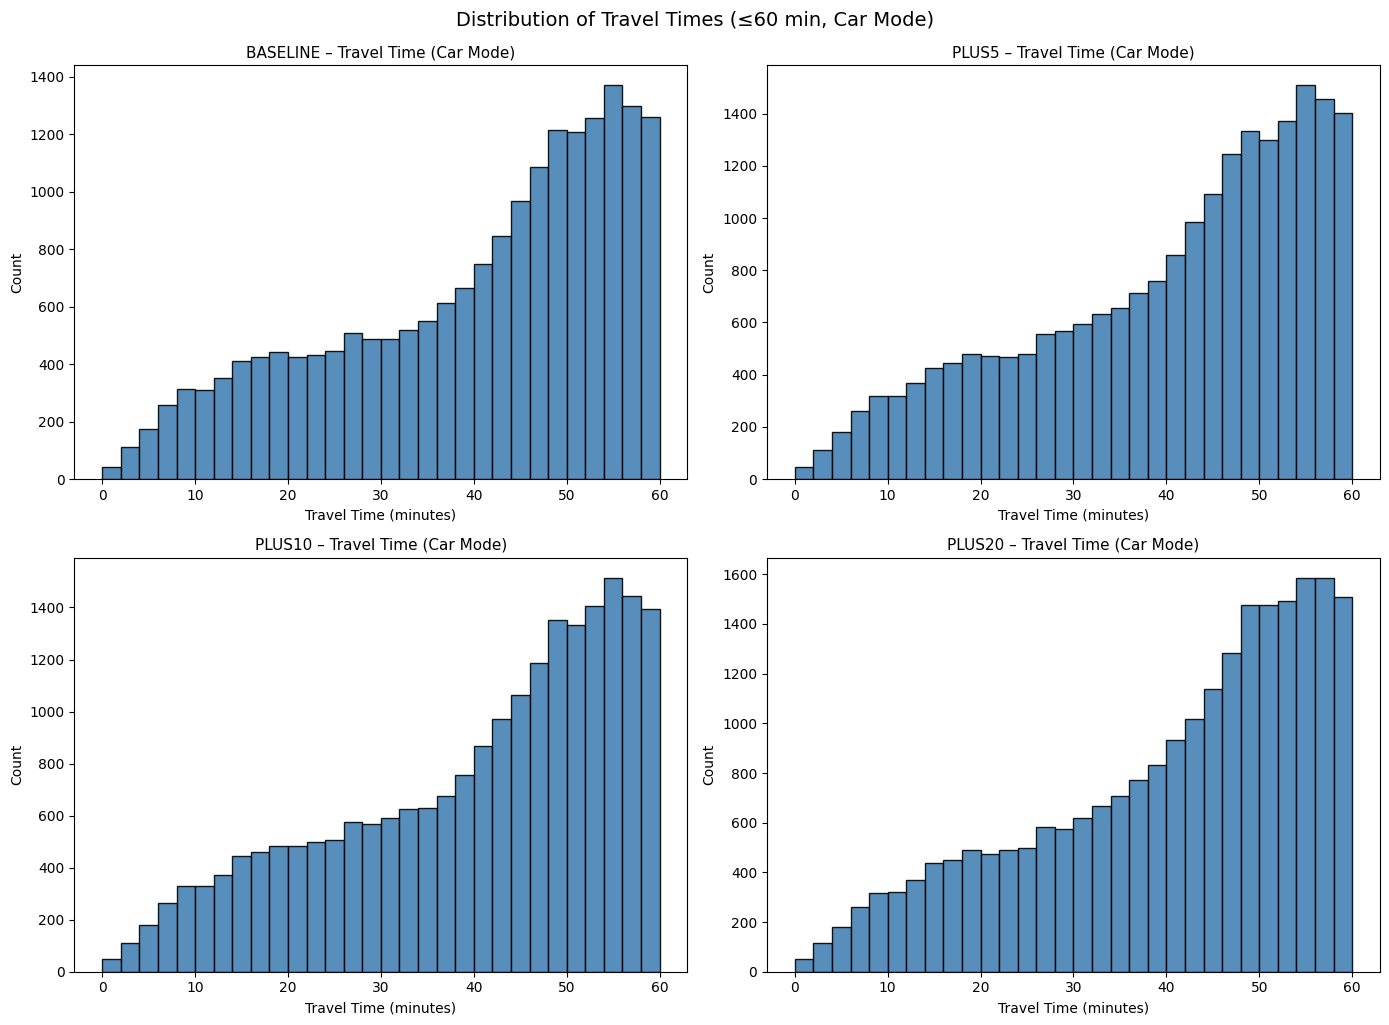

In [18]:
# ----------------------------------------------------------
# Step 5 – 2x2 Histograms and Summary of Travel Time (Car Mode)
# ----------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (label, df_scenario) in enumerate(scenario_travel_matrices.items()):
    ax = axes[i]

    # Histogram
    df_scenario["travel_time_car"].hist(
        bins=30,
        color="steelblue",
        edgecolor="black",
        alpha=0.9,
        ax=ax
    )

    ax.set_title(f"{label.upper()} – Travel Time (Car Mode)", fontsize=11)
    ax.set_xlabel("Travel Time (minutes)")
    ax.set_ylabel("Count")
    ax.grid(False)

    # Optional: Show basic stats inline in title or print below
    print(f"\n--- {label.upper()} SCENARIO ---")
    print(df_scenario["travel_time_car"].describe())

plt.tight_layout()
plt.suptitle("Distribution of Travel Times (≤60 min, Car Mode)", fontsize=14, y=1.02)
plt.show()


In [19]:
# ----------------------------------------------------------
# Step 5 – Apply Travel Time Decay Function (Car Mode, 0–60 min)
# ----------------------------------------------------------

def apply_decay_car(travel_time):
    """
    Updated decay weights for car travel time:
    - 0–10 min: 1.0
    - 10–20 min: 0.75
    - 20–30 min: 0.5
    - 30–40 min: 0.3
    - 40–50 min: 0.15
    - 50–60 min: 0.05
    - >60 min: 0.01 (shouldn’t occur but included for robustness)
    """
    if travel_time <= 10:
        return 1.0
    elif travel_time <= 20:
        return 0.75
    elif travel_time <= 30:
        return 0.5
    elif travel_time <= 40:
        return 0.3
    elif travel_time <= 50:
        return 0.15
    elif travel_time <= 60:
        return 0.05
    else:
        return 0.01

# Apply decay function to each scenario's travel matrix
for label, df in scenario_travel_matrices.items():
    df["decay_weight"] = df["travel_time_car"].apply(apply_decay_car)
    scenario_travel_matrices[label] = df  # update the dictionary

    # Summary count per scenario
    print(f"\nDecay weights applied – {label.upper()} scenario:")
    print(df["decay_weight"].value_counts().sort_index())



Decay weights applied – BASELINE scenario:
decay_weight
0.05    6397
0.15    4866
0.30    2837
0.50    2301
0.75    1947
1.00     905
Name: count, dtype: int64

Decay weights applied – PLUS5 scenario:
decay_weight
0.05    7036
0.15    5511
0.30    3353
0.50    2543
0.75    2038
1.00     918
Name: count, dtype: int64

Decay weights applied – PLUS10 scenario:
decay_weight
0.05    7092
0.15    5442
0.30    3279
0.50    2634
0.75    2087
1.00     932
Name: count, dtype: int64

Decay weights applied – PLUS20 scenario:
decay_weight
0.05    7648
0.15    5846
0.30    3595
0.50    2617
0.75    2069
1.00     921
Name: count, dtype: int64


In [28]:
# ----------------------------------------------------------
# Step 6 – Compute Supply-to-Demand Ratios (Rj) for Each Scenario
# ----------------------------------------------------------

scenario_rj_tables = {}

for label, df_travel in scenario_travel_matrices.items():
    print(f"\n--- Calculating Rj for: {label.upper()} ---")
    
    # 1. Clean merge keys
    df_travel["origin_name"] = df_travel["origin_name"].astype(str).str.strip()
    gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()
    
    # 2. Remove pre-existing demand columns if they exist
    df_travel = df_travel.drop(columns=["ct_total_demand", "lsoa21cd"], errors="ignore")
    
    # 3. Merge in LSOA-level demand values
    df_travel = df_travel.merge(
        gdf_lsoa[["lsoa21cd", "ct_total_demand"]],
        how="left",
        left_on="origin_name",
        right_on="lsoa21cd"
    ).drop(columns=["lsoa21cd"], errors="ignore")

    # 4. Drop rows missing demand (e.g. bad joins)
    df_travel = df_travel.dropna(subset=["ct_total_demand"])

    # 5. Weighted demand: Wi,j = Di × decay(dij)
    df_travel["weighted_demand"] = df_travel["ct_total_demand"] * df_travel["decay_weight"]

    # 6. Aggregate total weighted demand per site
    df_demand = (
        df_travel
        .groupby("destination_name", as_index=False)["weighted_demand"]
        .sum()
        .rename(columns={"weighted_demand": "total_weighted_demand"})
    )

    # 7. Get scanner count per site
    df_sites = scenario_ct_sites[label]
    df_supply = df_sites[["destination_name", "scanner_count"]].copy()

    # 8. Merge demand and supply
    df_rj = df_demand.merge(df_supply, on="destination_name", how="left")
    df_rj["scanner_count"] = df_rj["scanner_count"].fillna(1)  # fail-safe fallback

    # 9. Calculate Rj and Rj_per_1000
    df_rj["Rj"] = df_rj["scanner_count"] / df_rj["total_weighted_demand"]
    df_rj["Rj_per_1000"] = df_rj["Rj"] * 1000

    # 10. Save to dictionary
    scenario_rj_tables[label] = df_rj

    # 11. Print summary
    print(df_rj[["Rj", "Rj_per_1000"]].describe())



--- Calculating Rj for: BASELINE ---
              Rj  Rj_per_1000
count  29.000000    29.000000
mean    0.000063     0.062821
std     0.000038     0.037907
min     0.000014     0.013513
25%     0.000031     0.031149
50%     0.000056     0.055754
75%     0.000076     0.076314
max     0.000159     0.159318

--- Calculating Rj for: PLUS5 ---
              Rj  Rj_per_1000
count  33.000000    33.000000
mean    0.000061     0.060774
std     0.000036     0.036253
min     0.000014     0.013513
25%     0.000031     0.031149
50%     0.000049     0.049053
75%     0.000076     0.076151
max     0.000159     0.159318

--- Calculating Rj for: PLUS10 ---
              Rj  Rj_per_1000
count  33.000000    33.000000
mean    0.000063     0.063346
std     0.000038     0.038429
min     0.000014     0.013513
25%     0.000028     0.027655
50%     0.000056     0.055754
75%     0.000086     0.086392
max     0.000159     0.159318

--- Calculating Rj for: PLUS20 ---
              Rj  Rj_per_1000
count  35.00000

In [30]:
# ----------------------------------------------------------
# Step 6a – Compute Supply-to-Demand Ratios (Rj) for Each Scenario
# ----------------------------------------------------------

df_rj_per_scenario = {}  

for label, df_travel in scenario_travel_matrices.items():
    print(f"\n--- Calculating Rj for: {label.upper()} ---")

    # 1. Clean origin and LSOA keys
    df_travel["origin_name"] = df_travel["origin_name"].astype(str).str.strip()
    gdf_lsoa["lsoa21cd"] = gdf_lsoa["lsoa21cd"].astype(str).str.strip()

    # 2. Remove old columns to avoid merge errors
    df_travel = df_travel.drop(columns=["ct_total_demand", "lsoa21cd"], errors="ignore")

    # 3. Merge in LSOA-level demand
    df_travel = df_travel.merge(
        gdf_lsoa[["lsoa21cd", "ct_total_demand"]],
        left_on="origin_name", right_on="lsoa21cd", how="left"
    ).drop(columns=["lsoa21cd"], errors="ignore")

    # 4. Drop rows with missing demand
    df_travel = df_travel.dropna(subset=["ct_total_demand"])

    # 5. Compute decay-weighted demand
    df_travel["weighted_demand"] = df_travel["ct_total_demand"] * df_travel["decay_weight"]

    # 6. Group by CT destination and sum weighted demand
    df_demand = (
        df_travel
        .groupby("destination_name", as_index=False)["weighted_demand"]
        .sum()
        .rename(columns={"weighted_demand": "total_weighted_demand"})
    )

    # 7. Get scanner counts for this scenario
    df_sites = scenario_ct_sites[label]  # <- ensure this dictionary is defined above
    df_supply = df_sites[["destination_name", "scanner_count"]].copy()

    # 8. Merge demand + supply
    df_rj = df_demand.merge(df_supply, on="destination_name", how="left")
    df_rj["scanner_count"] = df_rj["scanner_count"].fillna(1)  # assume 1 if missing

    # 9. Calculate Rj and scaled version
    df_rj["Rj"] = df_rj["scanner_count"] / df_rj["total_weighted_demand"]
    df_rj["Rj_per_1000"] = df_rj["Rj"] * 1000

    # 10. Store output
    df_rj_per_scenario[label] = df_rj[["destination_name", "Rj", "Rj_per_1000"]]

    # 11. Summary
    print(df_rj[["Rj", "Rj_per_1000"]].describe())



--- Calculating Rj for: BASELINE ---
              Rj  Rj_per_1000
count  29.000000    29.000000
mean    0.000063     0.062821
std     0.000038     0.037907
min     0.000014     0.013513
25%     0.000031     0.031149
50%     0.000056     0.055754
75%     0.000076     0.076314
max     0.000159     0.159318

--- Calculating Rj for: PLUS5 ---
              Rj  Rj_per_1000
count  33.000000    33.000000
mean    0.000061     0.060774
std     0.000036     0.036253
min     0.000014     0.013513
25%     0.000031     0.031149
50%     0.000049     0.049053
75%     0.000076     0.076151
max     0.000159     0.159318

--- Calculating Rj for: PLUS10 ---
              Rj  Rj_per_1000
count  33.000000    33.000000
mean    0.000063     0.063346
std     0.000038     0.038429
min     0.000014     0.013513
25%     0.000028     0.027655
50%     0.000056     0.055754
75%     0.000086     0.086392
max     0.000159     0.159318

--- Calculating Rj for: PLUS20 ---
              Rj  Rj_per_1000
count  35.00000

In [31]:
# ----------------------------------------------------------
# Step 7 – Merge Rj Back to Travel Matrix and Aggregate to LSOA
# ----------------------------------------------------------

scenario_access_scores = {}  # Stores final LSOA accessibility GeoDataFrames

for label in scenario_travel_matrices:
    print(f"\n--- Computing Enhanced 3SFCA Score for: {label.upper()} ---")

    # 1. Get travel matrix and Rj per scenario
    df_travel = scenario_travel_matrices[label].copy()
    df_rj = df_rj_per_scenario[label].copy()

    # 2. Merge Rj into travel matrix on destination
    df_travel = df_travel.merge(df_rj, on="destination_name", how="left")

    # 3. Compute accessibility score: Aᵢ = ∑ Rⱼ × f(dᵢⱼ)
    df_access = df_travel.copy()
    df_access["access_component"] = df_access["Rj"] * df_access["decay_weight"]

    # 4. Group by origin LSOA to compute ∑ Rⱼ × f(dᵢⱼ)
    df_lsoa_scores = (
        df_access
        .groupby("origin_name", as_index=False)["access_component"]
        .sum()
        .rename(columns={"origin_name": "lsoa21cd", "access_component": f"enhanced_3sfca_score_{label}"})
    )

    # 5. Merge with full LSOA GeoDataFrame
    gdf_result = gdf_lsoa.merge(df_lsoa_scores, on="lsoa21cd", how="left")

    # 6. Fill missing scores with 0 (if LSOA had no reachable CT sites)
    score_col = f"enhanced_3sfca_score_{label}"
    gdf_result[score_col] = gdf_result[score_col].fillna(0)

    # 7. Save result
    scenario_access_scores[label] = gdf_result[[*gdf_lsoa.columns, score_col]]

    print(f"Added column: {score_col} | Missing scores filled with 0.")

# Optional: Merge all scores back into main gdf_lsoa
for label, gdf in scenario_access_scores.items():
    score_col = f"enhanced_3sfca_score_{label}"
    gdf_lsoa[score_col] = gdf[score_col]

print("\nAll enhanced 3SFCA scores merged back to gdf_lsoa.")



--- Computing Enhanced 3SFCA Score for: BASELINE ---
Added column: enhanced_3sfca_score_baseline | Missing scores filled with 0.

--- Computing Enhanced 3SFCA Score for: PLUS5 ---
Added column: enhanced_3sfca_score_plus5 | Missing scores filled with 0.

--- Computing Enhanced 3SFCA Score for: PLUS10 ---
Added column: enhanced_3sfca_score_plus10 | Missing scores filled with 0.

--- Computing Enhanced 3SFCA Score for: PLUS20 ---
Added column: enhanced_3sfca_score_plus20 | Missing scores filled with 0.

All enhanced 3SFCA scores merged back to gdf_lsoa.


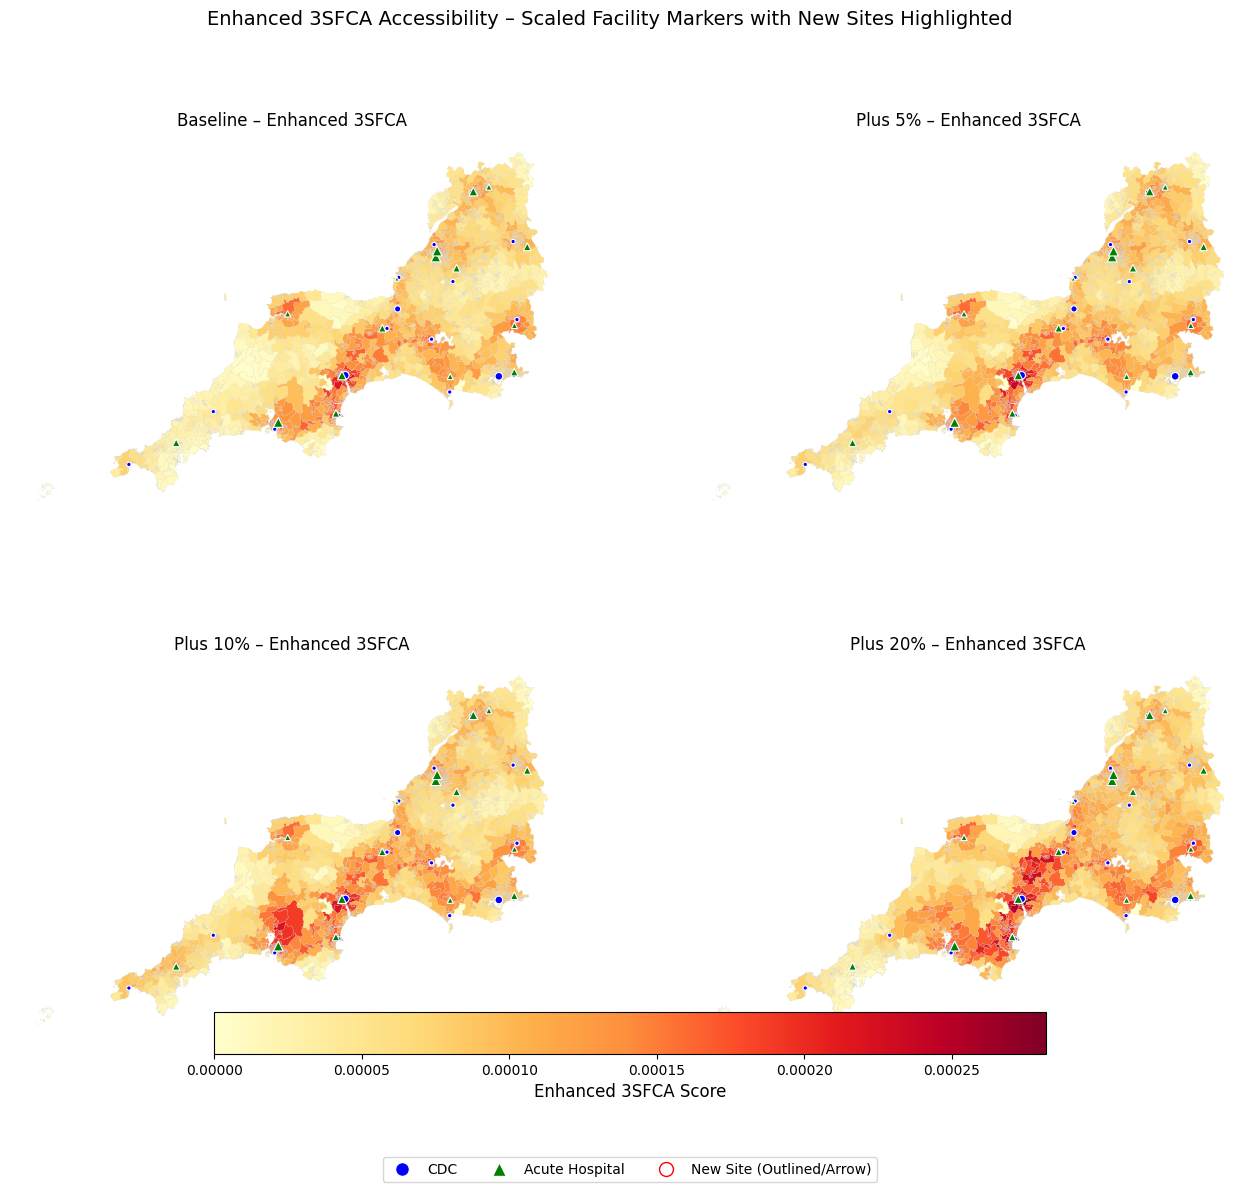

In [36]:
# ----------------------------------------------------------
# Step 8a – 2×2 Enhanced 3SFCA Maps with Scaled Facility Markers + New Site Labels
# ----------------------------------------------------------

import matplotlib.colors as colors
from matplotlib.lines import Line2D

# Ensure destination_name exists
for df in [cdc_gdf, acute_gdf]:
    if "destination_name" not in df.columns:
        df["destination_name"] = df["lsoa21cd"]

# Scenario label and corresponding column names
scenario_cols = {
    "Baseline": "enhanced_3sfca_score_baseline",
    "Plus 5%": "enhanced_3sfca_score_plus5",
    "Plus 10%": "enhanced_3sfca_score_plus10",
    "Plus 20%": "enhanced_3sfca_score_plus20"
}

# Compute shared colour scale
all_scores = pd.concat([gdf_lsoa[col] for col in scenario_cols.values()])
vmin, vmax = all_scores.min(), all_scores.max()

# Scale for facility markers
size_scale = 10

# Create 2×2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (label, col_name) in enumerate(scenario_cols.items()):
    ax = axes[i]

    # Base choropleth
    gdf_lsoa.plot(
        column=col_name,
        cmap="YlOrRd",
        linewidth=0.1,
        edgecolor="lightgrey",
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        legend=False,
        missing_kwds={"color": "lightgrey"}
    )

    # CDC
    is_new_cdc = cdc_gdf["destination_name"].isin(new_site_flags.get(label, set()))
    cdc_gdf.plot(
        ax=ax,
        color="blue",
        markersize=cdc_gdf["scanner_count"] * size_scale,
        marker="o",
        edgecolor=np.where(is_new_cdc, "red", "white"),
        linewidth=0.8,
        label="CDC"
    )

    # Annotate new CDCs
    for _, row in cdc_gdf[is_new_cdc].iterrows():
        ax.annotate("New CDC", xy=(row.geometry.x, row.geometry.y),
                    xytext=(row.geometry.x + 1000, row.geometry.y + 1000),
                    textcoords="data", fontsize=8,
                    arrowprops=dict(arrowstyle="->", color="red"))

    # Acute
    is_new_acute = acute_gdf["destination_name"].isin(new_site_flags.get(label, set()))
    acute_gdf.plot(
        ax=ax,
        color="green",
        markersize=acute_gdf["scanner_count"] * size_scale,
        marker="^",
        edgecolor=np.where(is_new_acute, "red", "white"),
        linewidth=0.8,
        label="Acute Hospital"
    )

    # Annotate new Acute
    for _, row in acute_gdf[is_new_acute].iterrows():
        ax.annotate("New Acute", xy=(row.geometry.x, row.geometry.y),
                    xytext=(row.geometry.x + 1000, row.geometry.y + 1000),
                    textcoords="data", fontsize=8,
                    arrowprops=dict(arrowstyle="->", color="red"))

    ax.set_title(f"{label} – Enhanced 3SFCA", fontsize=12)
    ax.axis("off")

# Shared colourbar
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.045, pad=0.04)
cbar.set_label("Enhanced 3SFCA Score", fontsize=12)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='CDC',
           markerfacecolor='blue', markeredgecolor='white', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Acute Hospital',
           markerfacecolor='green', markeredgecolor='white', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='New Site (Outlined/Arrow)',
           markerfacecolor='none', markeredgecolor='red', markersize=10, linewidth=0.8)
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, frameon=True, fontsize=10)
plt.subplots_adjust(bottom=0.12, top=0.92)
plt.suptitle("Enhanced 3SFCA Accessibility – Scaled Facility Markers with New Sites Highlighted", fontsize=14)
plt.savefig("enhanced_3sfca_scaled_markers_2x2_arrows.png", dpi=300, bbox_inches="tight")
plt.show()


In [61]:
# Step 1 – Convert each scenario DataFrame to a GeoDataFrame
scenario_gdfs = {}
for label, df in site_dfs.items():
    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
        crs="EPSG:4326"
    )
    scenario_gdfs[label] = gdf

# Step 2 – Identify new sites per scenario (excluding baseline)
# Output both: a) Full scenario GeoDataFrames with 'is_new' flag; b) Separate dict of new sites
all_sites_gdfs = {}     # with 'is_new' flag for completeness
new_sites_gdfs = {}     # only new sites (optional use)

for label, gdf in scenario_gdfs.items():
    gdf = gdf.copy()

    if label != "baseline":
        # Clean destination_name and match against new_site_flags
        gdf["destination_clean"] = gdf["destination_name"].str.strip().str.lower()
        new_flags_clean = {code.strip().lower() for code in new_site_flags.get(label, [])}

        gdf["is_new"] = gdf["destination_clean"].isin(new_flags_clean)
        new_sites_gdfs[label] = gdf[gdf["is_new"]]
    else:
        gdf["is_new"] = False  # no new sites in baseline

    all_sites_gdfs[label] = gdf  # store the full GeoDataFrame for each scenario


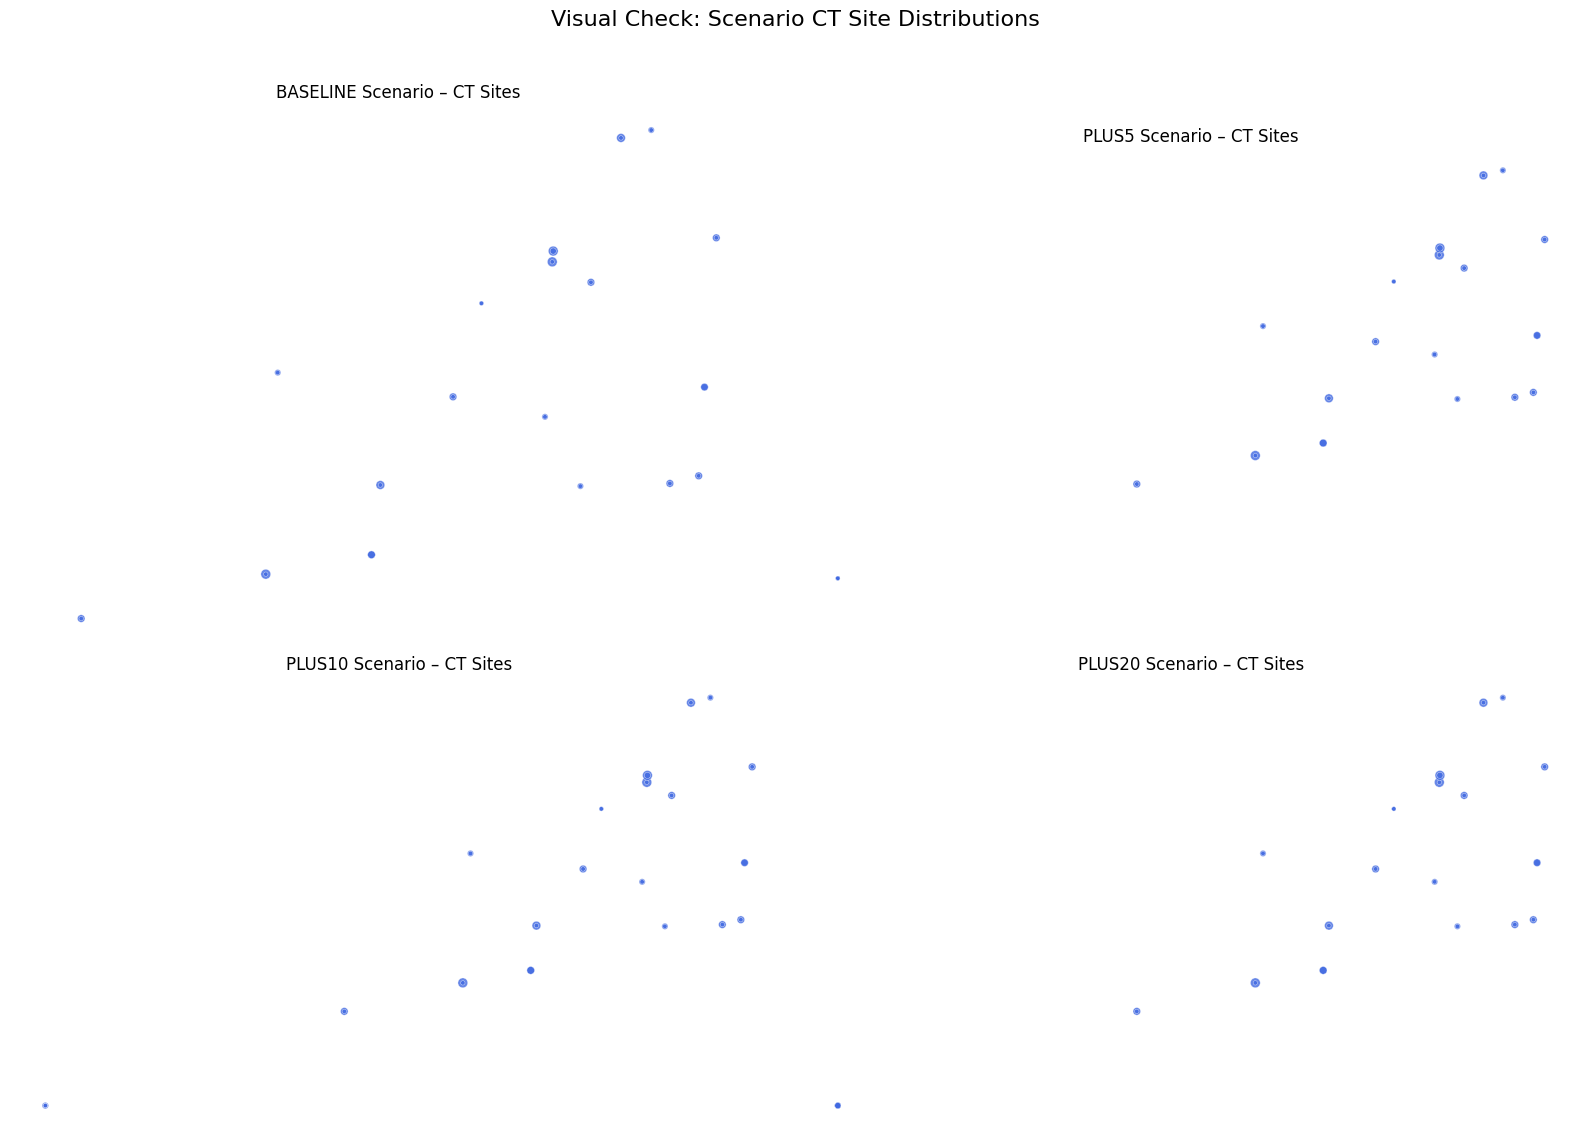

In [62]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Ensure Web Mercator for plotting
for label in all_sites_gdfs:
    all_sites_gdfs[label] = all_sites_gdfs[label].to_crs(epsg=3857)

# Marker size scaling
size_scale = 10

# Create 2×2 subplot grid for 4 scenarios
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, (label, gdf) in zip(axes, all_sites_gdfs.items()):
    gdf.plot(
        ax=ax,
        markersize=gdf["scanner_count"] * size_scale,
        color="royalblue",
        edgecolor="white",
        linewidth=0.3,
        alpha=0.8
    )

    ax.set_title(f"{label.upper()} Scenario – CT Sites", fontsize=12)
    ax.axis("off")

plt.suptitle("Visual Check: Scenario CT Site Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [63]:
# ----------------------------------------------------------
# Count Number of Sites and Scanners per Scenario
# ----------------------------------------------------------

site_summary = []

for label, gdf in scenario_gdfs.items():
    num_sites = len(gdf)
    total_scanners = gdf["scanner_count"].sum()
    site_summary.append({
        "Scenario": label,
        "Number of Sites": num_sites,
        "Total Scanners": total_scanners
    })

# Convert to DataFrame and display
df_site_summary = pd.DataFrame(site_summary).sort_values("Scenario")
print(df_site_summary)


   Scenario  Number of Sites  Total Scanners
0  baseline               36              78
2    plus10               42              86
3    plus20               44              94
1     plus5               40              82


In [65]:
print(df_cdc[['latitude', 'longitude']].head())
print(df_acute[['latitude', 'longitude']].head())
print(scenario_gdfs['baseline'][['latitude', 'longitude']].head())


   latitude  longitude
0 -2.416516  51.311327
1 -1.797518  51.071737
2 -1.829554  51.558467
3 -2.965115  51.331298
4 -2.597200  51.530526
   latitude  longitude
0 -2.071883  51.892120
1 -2.232073  51.866379
2 -3.121693  51.011574
3 -2.634712  50.944843
4 -2.596139  51.459183
    latitude  longitude
0  51.892120  -2.071883
1  51.866379  -2.232073
2  51.011574  -3.121693
3  50.944843  -2.634712
4  51.459183  -2.596139
